In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from proj_1_module import dynamics_solve

## Two Body Problem

Let there be 2 bodies with masses M, m. Then the energy (also Hamiltonian) is:

\begin{align}
    E = \frac{\mu v^2}{2} - \frac{G\mu(M+m)}{r}
\end{align}

where the reduced mass is:

\begin{align}
    \mu = \frac{Mm}{M+m}
\end{align}

Equations of motion for orbital dynamics problem are:

\begin{align}
    \dot{r} = v \\
    
    \dot{v} = -\frac{G(M+m)r}{r^3}
\end{align}

In [3]:
# Analytical Solution
angle = np.linspace(0, 2*np.pi, 360) 
radius = 150e9 #m

simul_x = radius * np.cos(angle) 
simul_y = radius * np.sin(angle)

### 1. Algorithm

Text(0.5, 1.0, 'Path of Earth Around Sun')

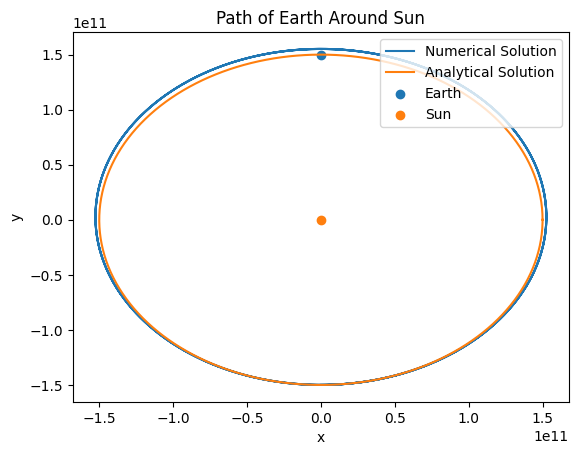

In [4]:
t0 = np.array([0., 0., 0., 0.])

# Input: [rx, ry, vx, vy]
s0 = np.array([0., -1.5e11, 30e3, 0.])

# Output: [vx, vy, ax, ay]
def derivative_func(t, s):
    derivatives = []

    # Append velocities
    derivatives.append(s[2])
    derivatives.append(s[3])

    mod_r = np.sqrt((s[0]**2) + (s[1]**2))
    #C = -1. # -G*(M+m)
    G = 6.674e-11 #Nm^2/kg^2 -> Solar mass
    M_sun = 1.989e30 #kg (m -> Au)
    M_earth = 5.972e24 #kg
    C = -G*(M_sun+M_earth)

    # Append accelerations
    derivatives.append((C*s[0])/(mod_r**3))
    derivatives.append((C*s[1])/(mod_r**3))

    return np.array(derivatives)

# EOM = Equations of motion
# Returns: [rx, ry, vx, vy]
eom = dynamics_solve(derivative_func, D=4, t_0=t0, 
                    h=1e3, N=100000, s_0=s0, method='RK4')

# 1 year ~ pi * 1e7 s
times = [i[0] for i in eom[0]]

# Assign positons to array
rx = [i[0] for i in eom[1]]
ry = [i[1] for i in eom[1]]

# Assign velocities to array
vx = [i[2] for i in eom[1]]
vy = [i[3] for i in eom[1]]

# Plot evolution of postion with time
plt.plot(rx, ry, label='Numerical Solution')
plt.plot(simul_x, simul_y, label='Analytical Solution')
plt.scatter(0, 1.5e11, label='Earth')
plt.scatter(0, 0, label='Sun')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend(loc='upper right')
plt.title('Path of Earth Around Sun') 

It is worth noting that in the above plot, the analytical solution of Earth's orbit is approximated to be a circle. In reality, the orbit actually takes the form of an ellipse with an eccentricity of ~0.016. This is quite low, allowing for the circular approximation. This is confirmed by the close agreement between the analytical solution and numerical solution, which provides a solution using orbital dynamics.

For this problem, a step size of h = 1000 was chosen. This was chosen considering the time scale of this problem, seconds. Earth makes a complete orbit in 1 which year which is roughly $\pi \times 10^7s$. Thus, the aim is to have h $\times$ N = $10^7$ to accurately capture the time scale. h was chosen such that it would be a large enough and a good enough estimate to capture the positon of postion of Earth at various points in time.

### 2. Proving Kepler's Third Law

\begin{align}
    T = 2\pi\sqrt{\frac{a^3}{GM_E}}
\end{align}

where a is the length of the semi-major axis

In [5]:
# Define range of omegas
init_states = np.array([[0., -1.5e8, 30e1, 0.],
                        [0., -1.5e8, 30e2, 0.],
                        [0., -1.5e8, 30e3, 0.],
                        [0., -1.5e8, 30e4, 0.],
                        [0., -1.5e8, 30e5, 0.]])
periods = []
a_s = []

for init_state in init_states:
    motion = dynamics_solve(derivative_func, D=4, t_0=t0, 
                     h = 1e3, N = 150000, s_0=init_state, method='RK4')
    r_x = [i[0] for i in motion[1]]
    r_y = [i[1] for i in motion[1]]

    # Calculate length of semi-major axis
    a_x = 0.5*(max(r_x) - min(r_x))
    a_y = 0.5*(max(r_y) - min(r_y))

    G = 6.674e-11 #Nm^2/kg^2 -> Solar mass
    M_sun = 1.989e30 #kg (m -> Au)
    M_earth = 5.972e24 #kg

    if a_x >= a_y:
        a_s.append(a_x)
        period = 2*np.pi*np.sqrt((a_x**3)/(G*M_earth))
        periods.append(period)
    else:
        a_s.append(a_y)
        period = 2*np.pi*np.sqrt((a_y**3)/(G*M_earth))
        periods.append(period)

# Perform a linear regression on logarithms of a_s and periods to extract power relation
log_a_s = np.log(a_s)
log_T = np.log(periods)
linear_fit = stats.linregress(log_a_s, log_T)
power = '{:.2f}'.format(linear_fit.slope)
print(f'The power relation between a and T is: T = a**{power}')

The power relation between a and T is: T = a**1.50


### 3. Conserved Quantities

There are 4 conserved quantities: 3 components of angular momentum and 1 of energy.

The energy (also Hamiltonian) is:

\begin{align}
    E = \frac{\mu v^2}{2} - \frac{G\mu(M+m)}{r}
\end{align}

and the angular momentum is given by:

\begin{align}
    \vec{L} = \vec{r} \times \mu\vec{v}
\end{align}

In [6]:
# Specify initial conditions generate motion of system
t0 = np.array([0., 0., 0., 0.])
initial_conditions = np.array([0., -1.5e11, 30e3, 0.])

G = 6.674e-11 # Nm^2/kg^2
M_sun = 1.989e30 #kg
M_earth = 5.972e24 #kg
mu = (M_sun*M_earth)/(M_sun+M_earth)

# Simulate motion of system
motion = dynamics_solve(derivative_func, D=4, t_0=t0, 
                     h = 1e3, N = 150000, s_0=initial_conditions, method='RK4')

# Collect components into their own lists
r_x = []
r_y = []
v_x = []
v_y = []

for i in range(len(motion[1])):
    r_x.append(motion[1][i][0])
    r_y.append(motion[1][i][1])
    v_x.append(motion[1][i][2])
    v_y.append(motion[1][i][3])

# Append third component r_z and v_z with zeroes for easier calculations
r_x = np.array(r_x)
r_y = np.array(r_y)
r_z = np.zeros(len(r_x))
r = np.c_[r_x, r_y, r_z]

v_x = np.array(v_x)
v_y = np.array(v_y)
v_z = np.zeros(len(v_x))
v = np.c_[v_x, v_y, v_z]

### 3.1. Conservation of Angular Momentum

In [7]:
# Take the cross product of v and r
cross_prod = []
for i in range(len(r)):
    # Calculate L
    cross_prod.append(mu*np.cross(r[i], v[i]))
cross_prod = np.array(cross_prod)

# If initial cross product of r and v are equal to all others, L is conserved
is_same = []
init_cross_prod = cross_prod[0]
for i in range(1, len(cross_prod)):
    if np.array_equal(init_cross_prod, cross_prod[i]):
        is_same.append(True)
is_same = np.array(is_same)

result = np.all(is_same)
if result == True:
    print(f'Angular momentum is conserved, and L = {init_cross_prod} kg m^2/s')

Angular momentum is conserved, and L = [-0.00000000e+00  0.00000000e+00  2.68739193e+40] kg m^2/s


### 3.2. Conservation of Energy

In [8]:
# Calculate energies and perform same check as we did for L
energies = []
for i in range(len(r)):
    r_term = np.sqrt(np.dot(r[i], r[i]))
    v_term = np.dot(v[i], v[i])
    energy = (0.5*mu*(v_term)) - ((G*mu*(M_sun+M_earth))/r_term)
    energies.append(energy)
energies = np.array(energies)

# If initial cross product of r and v are equal to all others, L is conserved
is_same = []
init_energy = energies[0]
for i in range(1, len(energies)):
    if init_energy == energies[i]:
        is_same.append(True)
is_same = np.array(is_same)

result = np.all(is_same)
if result == True:
    print(f'Energy is conserved, and E = {init_energy} J')

Energy is conserved, and E = -2.597663241731428e+33 J


### 4. Going Long: 10,000 Cycles

1 cycle ~ $\pi \times 10^7$ s

10,000 cycles ~ $\pi \times 10^{12}$ s ~ 12 years

We believe the RK4 algorithm is best suited given the approach we adapted for the 2 body problem. In general, it outperforms the RK2 and Euler methods as it is thorough and relies on more intermediate steps when making calculations.

**Initial Conditions:** "I initialized the positions of the planets to be at their respective average distance from the sun along the x-axis."

Source: https://pages.vassar.edu/magnes/2016/12/09/orbital-motion-of-our-solar-system/.

In [21]:
# Going to convert to AU units, so this actually runs...
def derivative_calc(t, s):
    derivatives = []

    # Append velocities
    derivatives.append(s[2])
    derivatives.append(s[3])

    mod_r = np.sqrt((s[0]**2) + (s[1]**2))
    #C = -G*(M_sun)
    C = -4. * (np.pi**2) # AU

    # Append accelerations
    derivatives.append((C*s[0])/(mod_r**3))
    derivatives.append((C*s[1])/(mod_r**3))

    return np.array(derivatives)

In [34]:
t0 = np.array([0., 0., 0., 0.])
s0 = np.array([1., 0., 0., 2*np.pi])

motion = dynamics_solve(derivative_calc, D=4, t_0=t0, 
                     h = 0.005, N = 200*12, s_0=s0, method='RK4')

Text(0.5, 1.0, 'Path of Earth Around Sun')

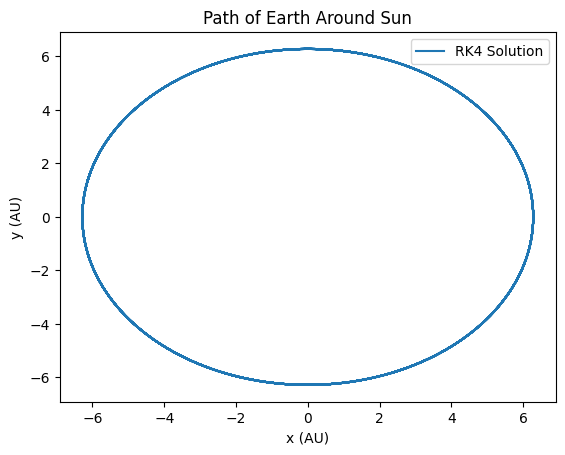

In [38]:
# 1 year ~ pi * 1e7 s
times = [i[0] for i in motion[0]]

# Assign positons to array
rx = [i[0] for i in motion[1]]
ry = [i[1] for i in motion[1]]

# Assign velocities to array
vx = [i[2] for i in motion[1]]
vy = [i[3] for i in motion[1]]

# Plot evolution of postion with time
plt.plot(rx, ry, label='RK4 Solution')
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.legend(loc='upper right')
plt.title('Path of Earth Around Sun')

To verify the solution, we plotted the x-componens and y-components of position against each other from 10,000 cycles, This matches the analytic solution where the orbit of the Earth around the sun is nearly circular and the radius is 1 AU, as expected from our initial conditions.